In [17]:
from app.models import Session, Article, Agency, Headline
import pandas as pd
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np

In [2]:
s = Session()

In [5]:
data = s.query(Headline.last_accessed, Headline.title, Headline.comp, Article.url, Agency.name, Agency._bias, Agency._credibility).join(Headline.article).join(Article.agency).all()
df = pd.DataFrame(data, columns=['date', 'title', 'comp', 'url', 'name', 'bias', 'credibility'])
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,title,comp,url,name,bias,credibility
0,2024-02-15 17:30:51.945675,Chicago will drop controversial ShotSpotter gu...,-0.4404,https://text.npr.org/1231394334,NPR,-1,4
1,2024-02-15 17:30:51.946010,A man died from Alaskapox last month. Here's w...,-0.5574,https://text.npr.org/1231437886,NPR,-1,4
2,2024-02-15 17:30:51.946326,Special counsel asks Supreme Court to move qui...,0.7430,https://text.npr.org/1231631584,NPR,-1,4
3,2024-02-15 17:30:51.946617,IDLES: Tiny Desk Concert,0.0000,https://text.npr.org/731395051,NPR,-1,4
4,2024-02-15 17:30:51.946920,Kelly Link's debut novel 'The Book of Love' is...,0.8074,https://text.npr.org/1231331761,NPR,-1,4


In [70]:
import string
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
include_stopwords = {'dear', 'New York Times', 'Getty Images', 'AP', "'s", "’", "``", "''", "—", "–", "“", "”", "‘", "’"}
include_stopwords.update(string.punctuation)
exclude_stopwords = {'not', 'no', 'nor', 'none', 'neither', 'never', 'nothing', 'nowhere', 'nobody', 'noone', 'nought', 'nay', 'nix', 'nil', 'negatory', 'nay', 'nope', 'nah', 'naw', 'no way', 'no way', 'ago', 'said', 'go'}
stopwords |= include_stopwords
stopwords -= exclude_stopwords
def remove_stop(text):
    return [word for word in text if word not in stopwords]

POS = ['NN', 'NNS', 'NNP', 'NNPS']

def pos_filter(text, pos=POS):
    return [word for word, tag in nltk.pos_tag(text) if tag in pos]

pipeline = [str.lower, nltk.word_tokenize, pos_filter, remove_stop]
def prepare(text, pipeline):
    for transform in pipeline:
        text = transform(text)
    return text

[nltk_data] Downloading package stopwords to /Users/mas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
df['tokens'] = df['title'].apply(prepare, pipeline=pipeline)
df.head()

,date,title,comp,url,name,bias,credibility,tokens
0,2024-02-15 17:30:51.945675,Chicago will drop controversial ShotSpotter gu...,-0.4404,https://text.npr.org/1231394334,NPR,-1,4,"[chicago, shotspotter, gunfire, detection, sys..."
1,2024-02-15 17:30:51.946010,A man died from Alaskapox last month. Here's w...,-0.5574,https://text.npr.org/1231437886,NPR,-1,4,"[man, alaskapox, month, virus]"
2,2024-02-15 17:30:51.946326,Special counsel asks Supreme Court to move qui...,0.7430,https://text.npr.org/1231631584,NPR,-1,4,"[counsel, asks, court, trump, immunity, case]"
3,2024-02-15 17:30:51.946617,IDLES: Tiny Desk Concert,0.0000,https://text.npr.org/731395051,NPR,-1,4,"[idles, desk, concert]"
4,2024-02-15 17:30:51.946920,Kelly Link's debut novel 'The Book of Love' is...,0.8074,https://text.npr.org/1231331761,NPR,-1,4,"[debut, book, love, heartfelt, strange]"


In [47]:
from collections import Counter
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
    counter = Counter()
    df[column].map(update)
    
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1
    idf_df.index.name = 'token'
    return idf_df

In [48]:
idf_df = compute_idf(df)
idf_df.head()

/var/folders/fd/vfz6tp5d6lg2p2jkv89sf3jm0000gn/T/ipykernel_50960/2397753361.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1


,df,idf
token,,
gunfire,18,7.080231
chicago,57,5.927551
system,30,6.569405
detection,5,8.361165
shotspotter,6,8.178843


In [49]:
def count_words(df, column='tokens', preprocess=None):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    counter = Counter()
    df[column].map(update)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df[freq_df['freq'] >= freq_df['freq'].min()]
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [50]:
freq_df = count_words(df)
freq_df.head()

,freq
token,
trump,1436
death,633
day,602
navalny,564
case,535


In [51]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']


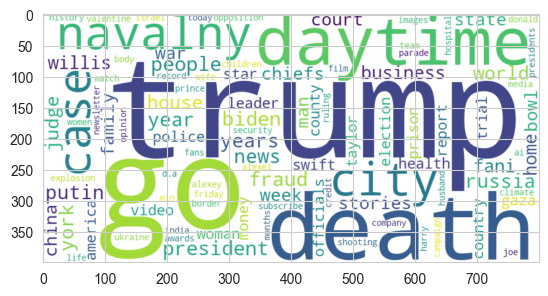

In [52]:
wc = wordcloud.WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_df['tfidf'])
plt.imshow(wc, interpolation='bilinear')

In [65]:
from textacy.extract import kwic
for k in kwic.keyword_in_context(' '.join(df['title']), ' go ', window_width=35):
    print(k)
    

("n Gupta's ‘Gym Routine’ Unions Must", ' Go ', 'Beyond Calling for a Cease-Fire in ')
("ley Mandadi's mother and stepfather", ' go ', 'to extreme lengths to prove her dea')
('e country. Do the punitive measures', ' go ', 'too far in cases like his? By Benja')
(' of conscripted men are starting to', ' go ', 'public with their frustration. They')
('tion May Be Complete, but the Games', ' Go ', 'On 💝Valentine’s Day Reveal! Huma Re')
(' Broken Tech Remote learning didn’t', ' go ', 'according to plan on Tuesday mornin')
("vka China's deflation problem won't", ' go ', 'away by itself REASON Charlie Kirk ')
('nt. Trump’s awful truth: the US can', ' go ', 'it alone The Success of Bitcoin ETF')
('ow the challenges they face as they', ' go ', 'about their work in minus 30 degree')
('irfield land Why do Super Bowl MVPs', ' go ', "to Disney? Japan's Renesas to buy A")
('ck’ Trump’s awful truth: the US can', ' go ', 'it alone Joe Biden’s TikTok Trouble')
('ne. Trump’s awful truth: the US can', ' g

In [69]:
# Search df title for phrase 'Go to' and show the agency:

df[df['title'].str.contains('go to item', case=False, na=False)]['title']

12226    Issa Rae and Hollywood’s Unkept Promises Andre...
12242    Books The Multiverse of Sarah J. Maas Megan Mc...
12254    movies Denis Villeneuve on Dune: Part Two Step...
12259    movies Christopher Nolan's Big Bet Jeffrey Klu...
16809    movies Christopher Nolan's Big Bet Jeffrey Klu...
17172    Issa Rae and Hollywood’s Unkept Promises Andre...
17665    movies Denis Villeneuve on Dune: Part Two Step...
17699    Books The Multiverse of Sarah J. Maas Megan Mc...
19230    Books The Multiverse of Sarah J. Maas Megan Mc...
19235    movies Christopher Nolan's Big Bet Jeffrey Klu...
19237    movies Denis Villeneuve on Dune: Part Two Step...
19238    Issa Rae and Hollywood’s Unkept Promises Andre...
Name: title, dtype: object